# Elliptic equations and the finite element method

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import dolfin as df
import numpy as np
import sympy as sp

df.set_log_level(30)

Trial functions:

In [2]:
class TrialFunction:
    x, c = sp.symbols("x c", real=True)
    k, l = sp.symbols("k l", positive=True, integer=True)
    
    def __init__(self, psi, x_s=0, x_f=1, k0=1):
        self._psi = psi
        self.x_s = x_s
        self.x_f = x_f
        self.k0 = k0
        
    def __call__(self, x, k):
        k += self.k0
        if np.isscalar(x):
            return float(self._psi(x, k))
        return np.array([float(self._psi(xn, k)) for xn in x])
    
    def psi(self, k=None):
        k = self._check_idx(k)
        return self._psi(self.x, k)
        
    def Dx(self, x=None, k=None):
        Dx = sp.diff(self.psi(k), self.x)
        return self._evaluate(Dx, x)
    
    def Dxx(self, x=None, k=None):
        Dx = sp.diff(self.psi(k), self.x)
        Dxx = sp.diff(Dx, self.x)
        return self._evaluate(Dxx, x)
    
    def S(self, k=None, l=None):
        if l is None: l = self.l
        S = self.psi(k)*self.psi(l)
        return self._integrate(S)
    
    def A(self, k=None, l=None):
        if l is None: l = self.l
        I = self.Dx(k=k)*self.Dx(k=l)
        return self._integrate(I)
    
    def b(self, f, k=None):
        I = self.psi(k)*f(self.x)
        return self._integrate(I)
    
    def _to_float(self, f, x):
        y = f.subs(self.x, x)
        if not y.free_symbols:
            return float(y)
        return y
        
    def _evaluate(self, f, x):
        if x is self.x or x is None:
            return f
        elif np.isscalar(x):
            return self._to_float(f, x)
        elif isinstance(x, (list, tuple, np.ndarray)):
            return np.array([self._to_float(f, xn) for xn in x])
        else:
            raise TypeError("Invalid type for x in TrailFunction.")
    
    def _integrate(self, f):
        I = sp.integrate(f, self.x)
        return I.subs(self.x, self.x_f) - I.subs(self.x, self.x_s)  
    
    def _check_idx(self, k):
        if isinstance(k, int):
            return k + self.k0
        elif k is None:
            return self.k
        elif isinstance(k, sp.Symbol):
            return k
        else:
            raise TypeError("index of TrailFunction should be int.")

Elliptic problem:

In [3]:
class Elliptic:
    def __init__(self, psi, f, N):
        self.N = N
        self.psi = psi
        self.f = f
        self.solve()
    
    def __call__(self, x):
        u = np.zeros_like(x, dtype=np.float64)
        for k in range(self.N):
            u += self.c[k]*self.psi(x=x, k=k)
        return u
    
    def symbolic(self):
        u = sp.core.numbers.Zero()
        for k in range(self.N):
            u += self.c[k]*self.psi(x=self.x, k=k)
        return u
    
    def solve(self):
        self.c = np.linalg.solve(self.A(), self.b())
        
    # does not handle Dirichlet boundary conditions
    def A(self):
        A = np.zeros((self.N, self.N))
        for k in range(self.N):
            for l in range(self.N):
                A[k, l] = self.psi.A(k, l)
        return A
    
    # does not handle Neumann conditions
    def b(self):
        b = np.zeros(self.N)
        for k in range(self.N):
            b[k] = self.psi.b(self.f, k)
        return b
        
    def Dxx(self, x=None):
        u_xx = np.zeros_like(x, dtype=np.float64)
        for k in range(self.N):
            u_xx += self.c[k]*self.psi.Dxx(x=x, k=k)
        return u_xx
    
    def L2(self, u_e):
        I = self.psi._integrate(u_e(self.x)**2)
        for k in range(self.N):
            I -= 2*self.c[k]*self.psi.b(u_e, k)
            I += self.c[k]**2*self.psi.S(k, k)
            for l in range(k):
                I += 2*self.c[k]*self.c[l]*self.psi.S(k, l)
        return I     
    
    @property
    def x(self):
        return self.psi.x

Some errornorms:

In [4]:
def print_norms(u_e, uh, x_points):
    e = [float(u_e(x)) - uh(x) for x in x_points]
    print(f"l_2: {np.linalg.norm(e):.2g}")
    print(f"l_inf: {np.linalg.norm(e, ord=np.inf):.2g}")

## Exercise 1

Consider the problem

$$
    -u_{xx} = x^2,
$$
on the unit interval with Dirichlet boundary conditions $u(0) = u(1) = 0$. 

Let the approximate solution be on the form

$$u = \sum_k u_k \psi_k (x), $$

where both the trial and test functions are given by 

$$\psi_k(x) = \sin(\pi k x),$$

for $k = 1, 2, ... 10$. The first derivative of the test/trial functions are therefore

$$\frac{\mathrm{d}}{\mathrm{d} x}\psi_k(x) = \pi k\cos(\pi k x).$$

In [5]:
def sine(x, k):
    return sp.sin(sp.pi*k*x)

u1 = Elliptic(psi=TrialFunction(sine, k0=1), f=lambda x: x*x, N=10) 

print(f"psi(x) = {u1.psi.psi()}")
print(f"psi_x(x) = {u1.psi.Dx()}")

psi(x) = sin(pi*k*x)
psi_x(x) = pi*k*cos(pi*k*x)


The weak formulation of the problem is 

$$
    \sum_k u_k \pi^2 k l \int_0^1\cos(\pi k x) \cos(\pi l x) \,\mathrm{d} x 
    = \int_0^1 x^2 \sin(\pi l x)\,\mathrm{d} x 
    ,
$$
for $l = 1, 2, ... 10$, giving rise to the linear system $A u = b$ with

$$
    A_{k l} = \pi^2 k l \frac{\delta_{k l}}{2},
$$

and 

$$
    b_l = \left[\frac{2 x}{(\pi l)^2}\sin{\pi l x} 
    - \left(\frac{x^2}{\pi l} - \frac{2}{(\pi l)^3}\right)\cos{\pi l x}
    \right]^1_0
    = 
    \begin{cases}
        - \frac{1}{\pi l} \quad\quad\quad\quad \text{if } l \text{ is even} \\ 
        \frac{1}{\pi l} - \frac{4}{\pi^3 l^3} \quad\quad \ \text{if } l \text{ is odd}
    \end{cases}.
$$


In [6]:
print(f"A_kl = {u1.psi.A()}")

k_even = sp.symbols("k", even=True, positive=True)
k_odd = sp.symbols("k", odd=True, positive=True)
print(f"b_k = {u1.psi.b(u1.f, k_even)}, even k.")
print(f"b_k = {u1.psi.b(u1.f, k_odd)}, odd k.")

A_kl = pi**2*k*l*Piecewise((0, Ne(k, l)), (1/2, True))
b_k = -1/(pi*k), even k.
b_k = 1/(pi*k) - 4/(pi**3*k**3), odd k.


This means that the coefficients are

$$
    u_k =     
    \begin{cases}
        - \frac{2}{(\pi k)^3} \quad\quad\quad\quad \text{if } k \text{ is even} \\ 
        \frac{2}{(\pi k)^3} - \frac{8}{(\pi k)^5} \quad\quad \ \text{if } k \text{ is odd}
    \end{cases} .
$$

In [7]:
print(f"u_k = {u1.psi.b(u1.f, k_even)/u1.psi.A(k_even, k_even)}, even k.")
print(f"u_k = {(u1.psi.b(u1.f, k_odd)/u1.psi.A(k_odd, k_odd)).simplify()}, odd k.")

u_k = -2/(pi**3*k**3), even k.
u_k = 2*(pi**2*k**2 - 4)/(pi**5*k**5), odd k.


The exact solution is given by

$$
    u_e(x) = -\frac{1}{12} x^4 + \frac{1}{12} x.
$$

<IPython.core.display.Javascript object>


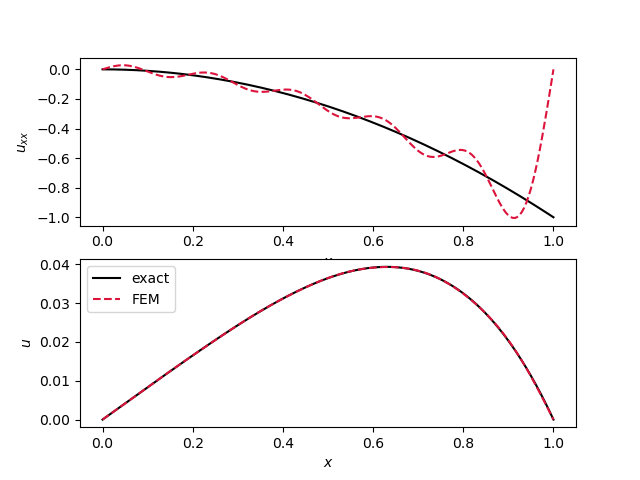

In [8]:
u_e = lambda x: -1/12*(x**4 - x)

x = np.linspace(0, 1, 200)
plt.figure()
plt.subplot(211)
plt.plot(x, -x*x, color="black", label="exact")
plt.plot(x, u1.Dxx(x), "--", color="crimson", label="FEM")
plt.xlabel(r"$x$")
plt.ylabel(r"$u_{xx}$")
plt.subplot(212)
plt.plot(x, u_e(x), color="black", label="exact")
plt.plot(x, u1(x), "--", color="crimson", label="FEM")
plt.xlabel(r"$x$")
plt.ylabel(r"$u$")
plt.legend();

The $L_2$ norm is given by

$$
    L_2 = \int_0^1 (u_e(x) - u(x))^2 \,\mathrm{d} x
    = \int_0^1 u_e^2(x) \,\mathrm{d} x 
    - 2\int_0^1 u_e(x)u(x) \,\mathrm{d} x 
    + \int_0^1 u^2(x) \,\mathrm{d} x.
$$

In this case, the first integral becomes

$$
  \int_0^1 u_e^2(x) \,\mathrm{d} x 
  = \frac{1}{144}\int_0^1 (x^2 - 2 x^5 + x^8) \,\mathrm{d} x
  = \frac{1}{144}\left(\frac{1}{3} - \frac{2}{6} + \frac{1}{9}\right) = \frac{1}{1296} .
$$

The last integral will be a linear combination of

$$
   c_k^2 \int_0^1 \psi_k^2(x) \,\mathrm{d}x
   = c_k^2 \int_0^1 \sin^2(k \pi x) \,\mathrm{d}x
   = \frac{c_k^2}{2}
$$

as the other integrals will yield zero only. Lastly, I will divide the middle integral into contributions from each trial function:

$$
  c_k \int_0^1 u_e(x)\psi_k(x) \,\mathrm{d}x 
  = \frac{c_k}{12} \int_0^1 (x - x^4)\sin(k \pi x) \,\mathrm{d}x 
  = \frac{c_k}{12}\left[\left(
         \frac{1}{(k \pi)^2} + \frac{4 x^3}{(k \pi)^2} - \frac{24 x}{(k \pi)^4}
      \right)\sin(k \pi x) 
  - \left(
      \frac{x}{k \pi} - \frac{x^4}{k \pi} + \frac{12 x^2}{(k \pi)^3} - \frac{24}{(k \pi)^5}
   \right)\cos(k \pi x)\right]_0^1
  = 
    \begin{cases}
        - \frac{c_k}{(\pi l)^3} \quad\quad\quad\quad \text{if } l \text{ is even} \\ 
        \frac{c_k}{(\pi l)^3} - \frac{4 c_k}{(\pi l)^5} \quad\quad \ \text{if } l \text{ is odd}
    \end{cases}.
$$

The total $L_2$ norm is then

$$
    L_2 = \frac{1}{1296} 
        + 2\sum_k \frac{(-1)^k c_k}{(k \pi)^3} 
        + 8\sum_{k_\text{odd}}\frac{c_k}{(k_\text{odd} \pi)^5} 
        + \frac{1}{2}\sum_k c_k^2
$$

In [9]:
k = np.arange(1, 11, 1)
a = np.pi*k
L2 = 1/1296 + 2*np.sum((-1)**k*u1.c/(a**3)) + 8*np.sum((u1.c/(a**5))[::2]) + np.sum(u1.c*u1.c)/2
print(f"{L2 = }.")

L2 = 3.212541857099821e-09.


Symbolic norm:

In [10]:
print(f"L2 = {float(u1.L2(u_e))}.")

L2 = 3.2125418573073846e-09.


Numerical norms:

In [11]:
x_points = np.linspace(0, 1, 1_000)
print_norms(u_e, u1, x_points)

l_2: 0.0018
l_inf: 0.00022


## Exercise 2

Changing the trial and test functions to the Bernstein polynomials:

$$\psi_k(x) = x^k(1 - x)^{10 - k},$$

for $k = 0, 1, 2, ... 10$.

In [13]:
def bernstein(x, k):
    return x**k*(1 - x)**(10 - k)

for k in range(11):
    print(f"{k = :02d}. psi(0) = {bernstein(x=0, k=k)} & psi(1) = {bernstein(x=1, k=k)}.")

k = 00. psi(0) = 1 & psi(1) = 0.
k = 01. psi(0) = 0 & psi(1) = 0.
k = 02. psi(0) = 0 & psi(1) = 0.
k = 03. psi(0) = 0 & psi(1) = 0.
k = 04. psi(0) = 0 & psi(1) = 0.
k = 05. psi(0) = 0 & psi(1) = 0.
k = 06. psi(0) = 0 & psi(1) = 0.
k = 07. psi(0) = 0 & psi(1) = 0.
k = 08. psi(0) = 0 & psi(1) = 0.
k = 09. psi(0) = 0 & psi(1) = 0.
k = 10. psi(0) = 0 & psi(1) = 1.


From this we can see that $c_0 = 0$ and $c_{10} = 0$.

In [14]:
u2 = Elliptic(TrialFunction(bernstein, k0=1), f=lambda x: x*x, N=9) 

print(f"psi(x) = {u2.psi(0, k=10)}")
print(f"psi(x) = {u2.psi.psi(k=0)}")
print(f"psi_x(x) = {u2.psi.Dx()}")

psi(x) = 0.0
psi(x) = x*(1 - x)**9
psi_x(x) = k*x**k*(1 - x)**(10 - k)/x + x**k*(1 - x)**(10 - k)*(k - 10)/(1 - x)


Solution:

<IPython.core.display.Javascript object>


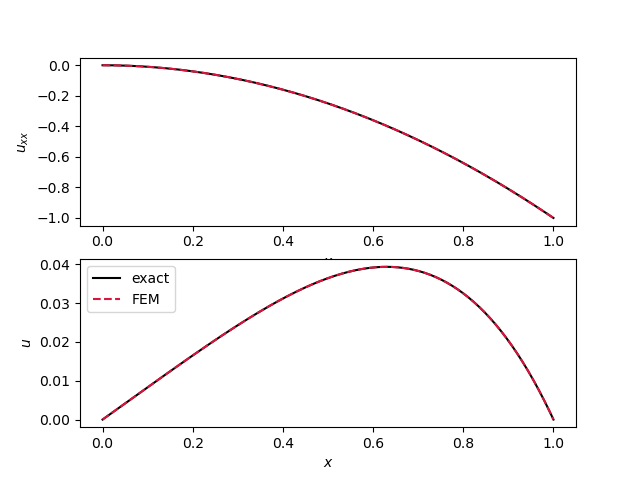

In [15]:
x = np.linspace(0, 1, 250)
plt.figure()
plt.subplot(211)
plt.plot(x, -x*x, color="black", label="exact")
plt.plot(x, u2.Dxx(x), "--", color="crimson", label="FEM")
plt.xlabel(r"$x$")
plt.ylabel(r"$u_{xx}$")
plt.subplot(212)
plt.plot(x, u_e(x), color="black", label="exact")
plt.plot(x, u2(x), "--", color="crimson", label="FEM")
plt.xlabel(r"$x$")
plt.ylabel(r"$u$")
plt.legend();

Norms:

In [16]:
print(f"L2 = {u2.L2(u_e)}.")
print_norms(u_e, u2, x_points)

L2 = -2.99134767520540E-15.
l_2: 5.2e-16
l_inf: 5.2e-17


## Exercise 3

Now considering 
$$ - u_{xx} = \sin(n\pi x)$$

for $n = 1$ and $n = 10$. The exact solution is then

$$ u(x) = \frac{\sin(n\pi x)}{(n \pi)^2}.$$


In [17]:
f_m1 = lambda x: sp.sin(sp.pi*x)
f_m10 = lambda x: sp.sin(10*sp.pi*x)

ue_m1 = lambda x: sp.sin(sp.pi*x)/(sp.pi**2)
ue_m10 = lambda x: sp.sin(10*sp.pi*x)/(100*sp.pi**2)

Using the same basis set as in exercise 1 we get:

In [18]:
print("n = 1")
u3_1 = Elliptic(u1.psi, f=f_m1, N=u1.N)
print(f"L2 = {float(u3_1.L2(ue_m1))}.")
print_norms(ue_m1, u3_1, x_points)

print("\nn = 10")
u3_1.f = f_m10
u3_1.solve()
print(f"L2 = {float(u3_1.L2(ue_m10))}.")
print_norms(ue_m10, u3_1, x_points)

n = 1
L2 = 6.466071840615436e-21.
l_2: 1.9e-16
l_inf: 1.4e-17

n = 10
L2 = -3.3847291961032994e-24.
l_2: 2.7e-18
l_inf: 2.2e-19


When using the same basis set as in exercise 2 we get:

In [19]:
print("n = 1")
u3_2 = Elliptic(u2.psi, f=f_m1, N=u2.N)
print(f"L2 = {float(u3_2.L2(ue_m1))}.")
print_norms(ue_m1, u3_2, x_points)

print("\nn = 10")
u3_2.f = f_m10
u3_2.solve()
print(f"L2 = {float(u3_2.L2(ue_m10))}.")
print_norms(ue_m10, u3_2, x_points)

n = 1
L2 = 1.0078249299521716e-16.
l_2: 6.4e-10
l_inf: 3.3e-11

n = 10
L2 = 3.761273422062825e-07.
l_2: 0.019
l_inf: 0.0011


## Exercise 4

Same as in E3, but with FEniCS.

In [20]:
x = sp.symbols("x[0]")


def to_expression(func, degree=5, t=0):
    f = func(x)
    if isinstance(f, sp.Expr): f = f.simplify()
    f_c = sp.printing.ccode(f)
    f_c = f_c.replace("M_PI", "pi").replace("log", "std::log")
    return df.Expression(f_c, degree=degree)


f1 = to_expression(f_m1)
f10 = to_expression(f_m10)

ue1 = to_expression(ue_m1)
ue10 = to_expression(ue_m10)

solver..

In [21]:
def solve(f, order=1, N=32):
    mesh = df.UnitIntervalMesh(N)
    V = df.FunctionSpace(mesh, "Lagrange", order)
    psi = df.TrialFunction(V)
    phi = df.TestFunction(V)
    u = df.Function(V)
    boundary = lambda x, on_boundary: on_boundary
    
    bc = df.DirichletBC(V, 0, boundary)
    a = df.inner(df.grad(psi), df.grad(phi))*df.dx
    L = f*phi*df.dx
    df.solve(a == L, u, bc)
    return u

m = 1:

In [23]:
for order in range(1, 4):
    uh = solve(f1, order)
    ue = df.interpolate(ue1, uh.function_space())
    e = np.abs(ue.vector()[:] - uh.vector()[:])
    print(f"l(inf) = {e.max():.2g} when order is {order}.")
    print(f"L2     = {df.errornorm(ue1, uh, 'L2', degree_rise=2):.2g} when order is {order}.\n")

l(inf) = 2.7e-14 when order is 1.
L2     = 6.3e-05 when order is 1.

l(inf) = 4.9e-09 when order is 2.
L2     = 3.9e-07 when order is 2.

l(inf) = 1.9e-09 when order is 3.
L2     = 2.2e-09 when order is 3.



m = 10:

In [25]:
for order in range(1, 4):
    uh = solve(f10, order)
    print(f"L2 = {df.errornorm(ue10, uh, 'L2', degree_rise=2):.2g} when order is {order}.")

L2 = 6.2e-05 when order is 1.
L2 = 3.8e-06 when order is 2.
L2 = 2.2e-07 when order is 3.


In [26]:
#df.norm?

Fenics lies, the $L_\infty$ does not work...